### This script creates a map of a cloud band and shows the properties: orientation, centroid and ellipse around the cloud band (blob)

#### Importation of appropriate packages

In [1]:
import os
import warnings
import datetime as dt

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap

from skimage import measure

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
LON_FORMAT = LongitudeFormatter(zero_direction_label=True, degree_symbol="")
LAT_FORMAT = LatitudeFormatter(degree_symbol="")
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from cloudbandpy.io_utilities import load_ymlfile, add_startend_datetime2config
from cloudbandpy.load_driver import run_load_data
from cloudbandpy.cb_detection import detection_workflow
from cloudbandpy.figure_tools import set_fontsize
from cloudbandpy.misc import wrapTo180

In [2]:
config_file = "../config/config_cbworkflow_southPacific.yml"
config = load_ymlfile(config_file, isconfigfile=True)
config_event = config.copy()
# Changing configs to adapt to this particular example
config_event["startdate"] = "20160418.00"
config_event["enddate"] = "20160418.00"
# update datetime dates from config file
add_startend_datetime2config(config_event)
dirdata = "../data/"
config_event["clouddata_path"] = os.path.join("../data")
config_event["parameters_file"] = os.path.join(
    "../parameters/parameters_southhemisphere.yml"
)
# No need to save any files
config_event["saved_dirpath"] = ""
config_event["save_dailyvar"] = False
config_event["save_listcloudbands"] = False

2023-11-23 17:56:00,475 - io_utilities.load_ymlfile - INFO: Configuration file loaded


In [3]:
olr2process, parameters, listofdates, lats, lons, resolution = run_load_data(
    config_event
)

2023-11-23 17:56:00,488 - load_driver.run_load_data - INFO: Loading data and parameters 
2023-11-23 17:56:00,492 - io_utilities.load_ymlfile - INFO: Parameters file loaded
2023-11-23 17:56:00,510 - io_utilities.load_dataset - INFO: Loading dataset from ../data
2023-11-23 17:56:00,511 - io_utilities.load_dataset - INFO: Loading 2016 --> 2016
2023-11-23 17:56:08,164 - io_utilities.get_variable_lonlat_from_domain - INFO: Subsetting dataset on domain done
2023-11-23 17:56:08,166 - io_utilities.make_daily_average - INFO: Computation of daily average
2023-11-23 17:56:08,196 - io_utilities.make_daily_average - INFO: Computation of daily average done
2023-11-23 17:56:08,198 - io_utilities.load_dataset - INFO: Dataset loaded


In [4]:
(
    _,
    _,
    _,
    _,
    _,
    list_of_candidates,
    _,
) = detection_workflow(
    var2process=olr2process,
    parameters=parameters,
    latitudes=lats,
    longitudes=lons,
    resolution=resolution,
    listofdates=listofdates,
    config=config,
)

2023-11-23 17:56:08,247 - cb_detection.detection_workflow - INFO: Cloud band detection in progress
2023-11-23 17:56:08,360 - cb_detection.detection_workflow - INFO: Cloud band detection done


In [5]:
print("Numbers of candidates to cloud band: "+ str(int(len(list_of_candidates[0]))))

Numbers of candidates to cloud band: 3


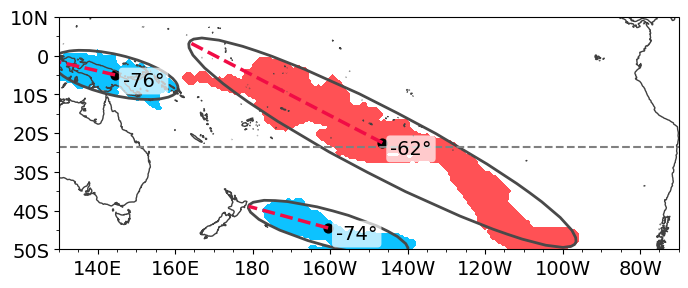

In [9]:
set_fontsize(14)

blob_colors = ["deepskyblue", "deepskyblue", "#ff474c"]


fig, ax = plt.subplots(
    figsize=(8, 6),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
)

# cloud_bands_masked = np.ma.masked_where(cloud_bands == 0, cloud_bands)
# ax.contourf(
#     lons, lats, cloud_bands_masked, transform=ccrs.PlateCarree(), cmap=cmap
# )

for i,cb in enumerate(list_of_candidates[0]):
    cbmap = (i + 1) * cb.cloud_band_array
    masked_map = np.ma.masked_where(cbmap == 0, cbmap)
    ax.contourf(
        lons,
        lats,
        masked_map,
        transform=ccrs.PlateCarree(),
        levels=range(4),
        alpha=0.95,
        colors=blob_colors[: masked_map.max()],
    )
    for props in measure.regionprops(cb.cloud_band_array):
        centroid = props.centroid
        x_centroid, y_centroid = (
            lons[int(centroid[1])].item(),
            lats[int(centroid[0])].item(),
        )

        # Extract ellipse properties
        major_axis_length = props.major_axis_length
        minor_axis_length = props.minor_axis_length
        orientation = props.orientation
        angle_deg = (orientation * 360) / (2 * np.pi)

        ax.scatter(
            x_centroid,
            y_centroid,
            color="k",
            marker="o",
            s=40,
            transform=ccrs.PlateCarree(),
        )

        # Create and plot the ellipse with proper orientation
        ellipse = Ellipse(
            (x_centroid, y_centroid),
            width=major_axis_length * 0.5,
            height=minor_axis_length * 0.5,
            angle=angle_deg - 90,
            edgecolor="#494949",
            facecolor="none",
            linewidth=2,
            transform=ccrs.PlateCarree(),
        )
        ax.add_patch(ellipse)

        # Plot major and minor axes using the provided code
        x0, y0 = x_centroid, y_centroid
        x1 = x0 + np.cos(orientation) * 0.25 * minor_axis_length
        y1 = y0 + np.sin(orientation) * 0.25 * minor_axis_length
        x2 = x0 - np.sin(orientation) * 0.25 * major_axis_length
        y2 = y0 + np.cos(orientation) * 0.25 * major_axis_length

        ax.plot((x0, x2), (y0, y2), "--", color="#f10c45", linewidth=2.5, transform=ccrs.PlateCarree())
        # ax.plot((x0, x1), (y0, y1), "--r", linewidth=2.5, transform=ccrs.PlateCarree())
        ax.text(
            x0 + 2,
            y0 - 3,
            "-"+str(int(angle_deg)) + r"°",
            color="k",
            backgroundcolor="white",
            transform=ccrs.PlateCarree(),
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'),
        )
    
else:  # no cloud band: we show an empty array made out the first cloud band array in the list
    emap = np.copy([el for el in list_of_candidates if len(el)][0][0].cloud_band_array)
    emap[emap != 0] = 0
    ax.contourf(lons, lats, np.ma.masked_where(emap == 0, emap), transform=ccrs.PlateCarree(), levels=range(4))



plt.axhline(y=-23.5, color='gray', linestyle='--')

lat_north, lat_south = 10, -50
lonticks = np.concatenate((np.arange(0, 180, 20), np.arange(-180, 0, 20)))
latticks = np.arange(-50, 20, 10)
ax.set_yticks(latticks, crs=ccrs.PlateCarree())
ax.set_xticks(lonticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LON_FORMAT)
ax.yaxis.set_major_formatter(LAT_FORMAT)
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.coastlines("50m", color="#404040")
ax.set_extent([wrapTo180(lons)[-1], wrapTo180(lons)[0], lat_south, lat_north])
ax.set_ylim([lat_south, lat_north])
original_startdate = config_event['startdate']
datetime_obj = dt.datetime.strptime(original_startdate, '%Y%m%d.%H')
formatted_startdate = datetime_obj.strftime('%Y-%m-%d')


plt.savefig(
    f"./ellipse_{formatted_startdate}.png",
    dpi=200,
    bbox_inches="tight",
)